### 깃허브 이슈 태거 만들기
이슈에 여러 개의 레이블을 할당할 수 있으므로 **다중 레이블 텍스트 분류** 문제

* 데이터 준비하기

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import time
import math
import requests
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm

def fetch_issues(owner="huggingface", repo="transformers", num_issues=10_000,
                 rate_limit=5_000):
    batch = []
    all_issues = []
    per_page = 100     # 페이지마다 반환되는 이슈 개수
    num_pages = math.ceil(num_issues / per_page)
    base_url = "https://api.github.com/repos"

    for page in tqdm(range(num_pages)):
        # 오픈 이슈와 클로즈 이슈를 모두 가져오기 위해 state=all로 쿼리합니다.
        query = f"issues?page={page}&per_page={per_page}&state=all"
        issues = requests.get(f"{base_url}/{owner}/{repo}/{query}")
        batch.extend(issues.json())

        if len(batch) > rate_limit and len(all_issues) < num_issues:
            all_issues.extend(batch)
            batch = []   # 다음 번 요청을 위해 비웁니다.
            print(f"깃허브 요청 한도에 도달했습니다. 한 시간 동안 중지합니다...")
            time.sleep(60 * 60 + 1)

    all_issues.extend(batch)
    df = pd.DataFrame.from_records(all_issues)
    df.to_json(f"github-issues-{repo}.jsonl", orient="records", lines=True)

C:\Users\knuyh\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [7]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"데이터프레임 크기: {df_issues.shape}")

데이터프레임 크기: (9930, 26)


In [8]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [9]:
df_issues["labels"] = (df_issues["labels"]
                       .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()
# labels 열에 있는 각 행은 깃허브 레이블의 리스트

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [10]:
df_issues["labels"].apply(lambda x : len(x)).value_counts().to_frame().T

labels,0,1,2,3,4,5
count,6440,3057,305,100,25,3


In [11]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"레이블 개수: {len(df_counts)}")
# 상위 8개 레이블
df_counts.to_frame().head(8).T

레이블 개수: 65


labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
count,2284,649,106,98,64,52,50,46


In [12]:
# 클래스 불균형으로 맞춰줌
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [13]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


In [14]:
# 이슈에 레이블 유무
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,count
split,
unlabeled,9489
labeled,441


In [15]:
for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[26][:500]}\n")
# 새로운 모델 구조 제안 : new model 태그

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [16]:
df_issues["text"] = (df_issues
                     .apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

In [17]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"삭제된 중복 이슈: {(len_before-len(df_issues))/len_before:.2%}")

삭제된 중복 이슈: 1.88%


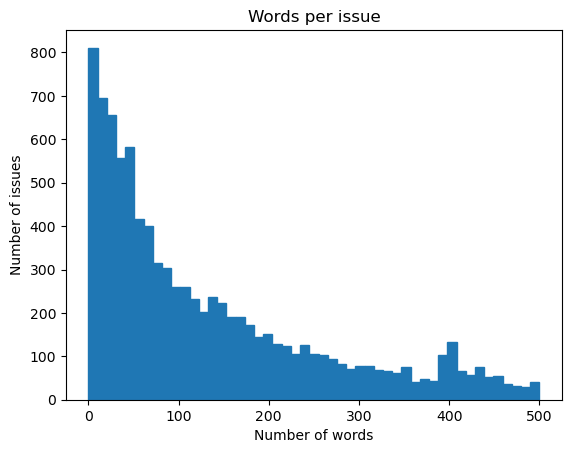

In [18]:
import numpy as np
import matplotlib.pyplot as plt

(df_issues["text"].str.split().apply(len)
 .hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

대부분의 텍스트가 매우 짧지만, 500단어가 넘는 이슈도 있다. (에러 메시지나 코드를 함께 포스팅한 경우)  
트랜스포머 모델의 문맥 크기는 512 개 토큰이나 그 이상이기에 일부 긴 이슈를 잘라내는 것이 전체 성능에 영향을 미칠 것 같지 않다.

* 훈련 세트 만들기

In [19]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [20]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels,
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

In [21]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [22]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

* 훈련 슬라이스 만들기  

훈련셋은 단 220개 샘플로 매우 적음, 샘플 개수가 더 적은 훈련 데이터의 슬라이스로 만들어 샘플 개수에 대한 성능을 그래프로 그려 성능 확인

In [23]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # 다음 슬라이스 크기를 채우는데 필요한 샘플 분할
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))


train_slices.append(all_indices), train_samples.append(len(ds["train"]))

train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [24]:
print("목표 분할 크기:")
print(train_samples)
print("실제 분할 크기:")
print([len(x) for x in train_slices])

목표 분할 크기:
[8, 16, 32, 64, 128, 223]
실제 분할 크기:
[10, 19, 36, 68, 134, 223]


### 나이브 베이즈 모델 만들기
* 정규 표현식, 수동 규칙 또는 매우 간단한 모델을 기반으로 하는 기준 모델이 실제로 문제를 잘 해결한다. 트랜스포머 같은 모델은 제품 환경에 배포하고 유지 관리가 대체로 더 복잡하다.
* 복잡한 모델을 탐색할 때 기준 모델이 간단한 검증 역할을 한다. BERT-large 모델을 훈련하고 검증셋에서 80% 정확도를 얻었다고 할때, 어려운 데이터셋이라 생각하고 끝낼지도 모른다. 하지만 로지스틱 회귀 같은 간단한 분류기가 95% 정확도 달성했다면, 모델에 버그가 있는지 의심하고 디버깅하게 된다.

<br>

* 텍스트 분류의 경우 좋은 기준점은 나이브 베이즈 분류기이다.
    * 간단하고 훈련 속도가 빠르며 입력의 변동에 매우 안정적

In [25]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [26]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

# 단어 순서 정보가 모두 없어짐 : BoW
for train_slice in train_slices:
    # 훈련 슬라이스와 테스트 데이터
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # 간단한 CountVectorizer를 사용해 텍스트를 토큰 카운트로 인코딩
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # 훈련
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # 예측 생성 및 평가
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # 결과 저장
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

In [28]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run,
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

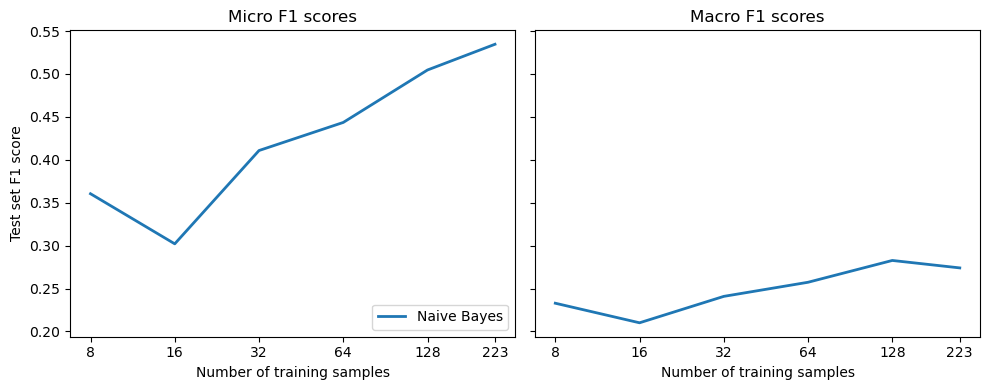

In [31]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

훈련 샘플 개수의 증가에 따라 두 점수 모두 향상

### 레이블이 없는 데이터 다루기
* 레이블링된 데이터가 전혀 없을 때 : 제로샷 분류
    * 작업별 말뭉치에서 추가로 미세 튜닝하지 않고 사전 훈련된 모델을 사용하는 것이 목표

In [28]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."

output = pipe(movie_desc + prompt)
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")
    
# fill-mask 파이프라인은 마스킹된 위치에 놓기에 가장 가능성이 높은 토큰 반환

토큰 animals:	0.103%
토큰 lions:	0.066%
토큰 birds:	0.025%
토큰 love:	0.015%
토큰 hunting:	0.013%


In [34]:
# 가장 가능성이 높은 토큰을 얻는 대신 주어진 토큰에 대한 확률 출력
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")

토큰 animals:	0.103%
토큰 cars:	0.001%


In [35]:
movie_desc = "In the movie transformers aliens \
can morph into a wide range of vehicles."

output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")    

토큰 cars:	0.139%
토큰 animals:	0.006%


텍스트 함의 : 모델이 두 개의 텍스트 구절이 서로 연결되는지 모순되는지 판단  
각 샘플은 전제(premise) / 가설(hypothesis) / 레이블 으로 구성  

    * 레이블은 entailment / neutral / contradiction
        * entailment : 전제 조건하에서 가설 텍스트가 참일 때 할당
        * contradiction : 전제 조건하에서 가설 텍스트가 거짓이거나 부적합일 때 할당
        * neutral : 두 경우에 해당하지 않을 때 할당

In [36]:
# 제로샷 분류를 위한 MNLI 모델
from transformers import pipeline

pipe = pipeline('zero-shot-classification')

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\knuyh\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [37]:
sample = ds["train"][0]
print(f"레이블: {sample['labels']}")
output = pipe(sample["text"], all_labels, multi_label=True) # 단일 레이블 분류를 위한 최댓값이 아닌 모든 점수 반환(multi_label=T)
print(output["sequence"][:400])
print("\n예측:")

for label, score in zip(output["labels"], output["scores"]):
    print(f"{label}, {score:.2f}")

레이블: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokeni

예측:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


In [38]:
def zero_shot_pipeline(example):
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predicted_labels"] = output["labels"]
    example["scores"] = output["scores"]
    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

샘플마다 어떤 레이블 할당할지  
선택지 1 ) 임계값 정의하고 이 임계값 초과한 모든 레이블 선택  
선택지 2 ) 점수가 높은 순으로 상위 k개 레이블 선택

In [39]:
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels"][i])
    else:
        raise ValueError("`threshold` 또는 `topk`로 지정해야 합니다.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

In [41]:
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
        y_true, y_pred, target_names=mlb.classes_, zero_division=0,
        output_dict=True)

In [42]:
macros, micros = [], []
topks = [1, 2, 3, 4]
for topk in topks:
    ds_zero_shot = ds_zero_shot.map(get_preds, batched=False,
                                    fn_kwargs={'topk': topk})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

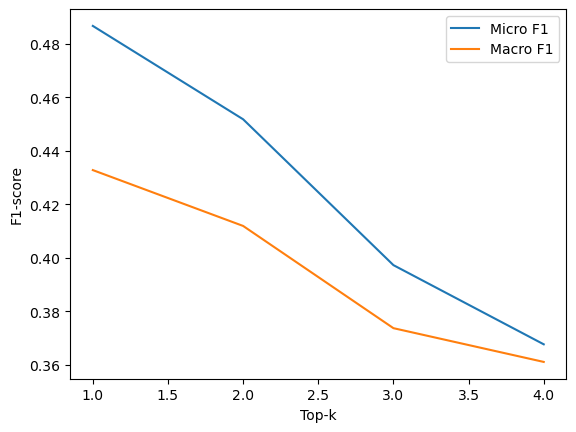

In [43]:
plt.plot(topks, micros, label = 'Micro F1')
plt.plot(topks, macros, label = 'Macro F1')
plt.xlabel('Top-k')
plt.ylabel('F1-score')
plt.legend(loc='best')
plt.show()

샘플당 점수가 가장 높은 레이블을 선택하는 방식이 최상의 결과를 냈다.

In [44]:
# 샘플당 하나 이상의 레이블 예측할 수 있으므로 임계값 방식과 비교
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds :
    ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'threshold':threshold})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

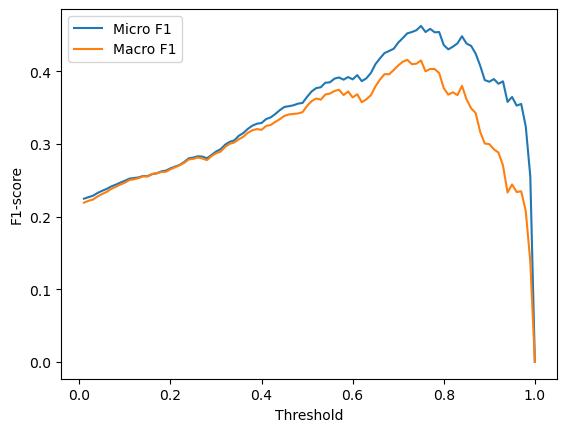

In [45]:
plt.plot(thresholds, micros, label = 'Micro F1')
plt.plot(thresholds, macros, label = 'Macro F1')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.legend(loc='best')
plt.show()

In [46]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'최상의 임곗값 (마이크로):{best_t}, F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'최상의 임곗값 (매크로):{best_t}, F1-score {best_macro:.2f}.')

최상의 임곗값 (마이크로):0.75, F1-score 0.46.
최상의 임곗값 (매크로):0.72, F1-score 0.42.


탑-1 결과보다 나쁘지만, 그래프에 정밀도/재현율의 트레이드오프가 확실하게 나타난다.  
임계값을 매우 낮게 설정하면 예측이 매우 많아져 정밀도가 낮아진다.   
임계값을 매우 높게 하면 예측하기 어려워져 재현율이 낮아진다.

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

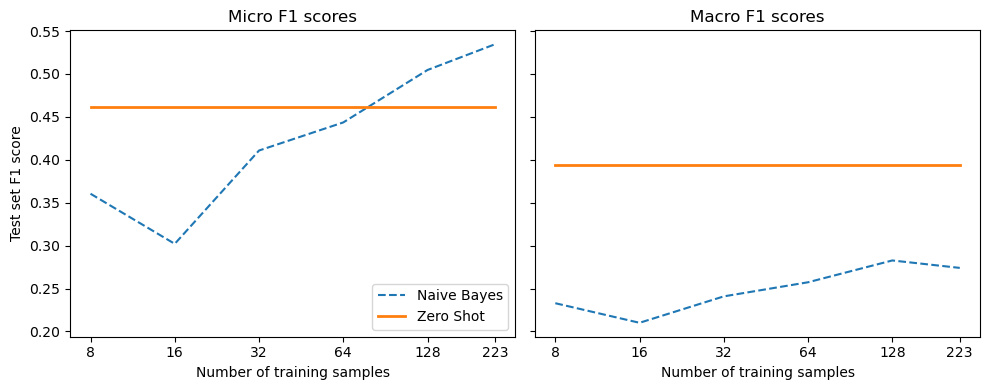

In [47]:
# 탑-1 사용해 테스트셋에서 제로샷 분류와 나이브 베이즈 비교
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk':1})
clf_report = get_clf_report(ds_zero_shot)

for train_slice in train_slices :
    macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score'])
    
plot_metrics(micro_scores, macro_scores, train_samples, 'Zero Shot')

- 레이블링된 샘플이 50개보다 적다면 제로샷 파이프라인이 기준 모델의 성능을 쉽게 추월함
- 샘플이 50개 이상이더라도 마이크로와 매크로 F1-score 모두 고려하면, 제로샷 파이프라인이 더 낫다. 마이크로 F1-score 결과를 보면, 기준 모델이 빈도가 높은 클래스에서 잘 동작하지만, 제로샷 파이프라인은 학습할 샘플이 피요하지 않기에 기준 모델보다 뛰어나다.


### 레이블링된 데이터가 적은 경우
* 데이터 증식
    * 역 번역 : 원본 언어로 된 텍스트를 기계 번역 사용해 하나 이상의 타깃 언어로 번역한 후 원본 언어로 다시 번역
        * 데이터가 많은 언어 또는 도메인 특화된 언어가 매우 많지 않은 말뭉치에서 잘 동작함
    * 토큰 섞기 : 훈련셋의 한 텍스트에서 동의어 교체, 단어 추가, 교환, 삭제 같은 간단한 변환을 임의로 선택해 수행

In [50]:
# 동의어 교체
from transformers import set_seed
import nlpaug.augmenter.word as naw

set_seed(3)
aug = naw.ContextualWordEmbsAug(model_path = 'distilbert-base-uncased', action='substitute')
text = 'Transformers are the most popular toys'
print(f"원본텍스트 : {text}")
print(f"증식된 텍스트 : {aug.augment(text)}")

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


원본텍스트 : Transformers are the most popular toys
증식된 텍스트 : ['transformers get the most interesting toys']


In [51]:
def augment_text(batch, transformations_per_example=1):
    text_aug, label_ids = [], []
    for text, labels in zip(batch["text"], batch["label_ids"]):
        text_aug += [text]
        label_ids += [labels]
        for _ in range(transformations_per_example):
            text_aug += aug.augment(text)
            label_ids += [labels]
    return {"text": text_aug, "label_ids": label_ids}

In [52]:
for train_slice in train_slices:
    ds_train_sample = ds["train"].select(train_slice)
    
    # 증식 결과를 펼쳐 레이블에 정렬
    ds_train_aug = (ds_train_sample.map(
        augment_text, batched=True, remove_columns=ds_train_sample.column_names)
                    .shuffle(seed=42))
    y_train = np.array(ds_train_aug["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    
    # 간단한 CountVectorizer를 사용해 텍스트를 토큰 카운트로 인코딩
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_aug["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])

    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)

    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)

    macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

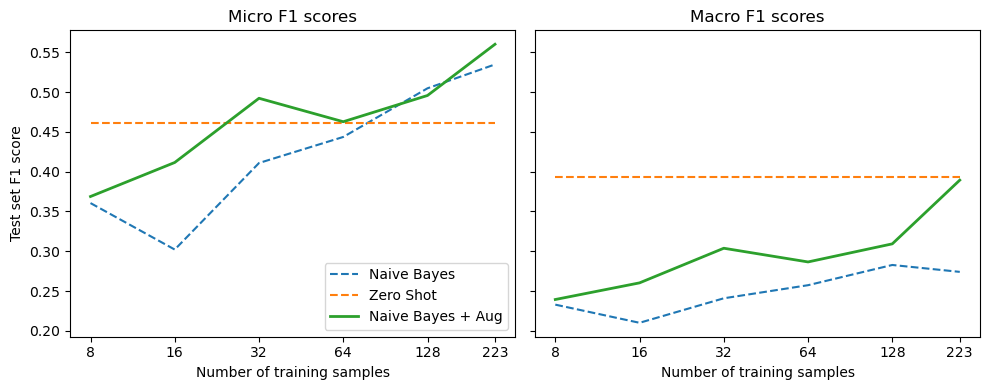

In [53]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

데이터 증식으로 나이브 베이즈 분류기의 점수 상승

* 임베딩을 룩업 테이블로 사용하기
    * 언어 모델을 사용해 레이블링된 전체 텍스트 임베딩
    * 저장된 임베딩에 최근접 이웃 검색 수행
    * 최근접 이웃의 레이블을 수집해 예측 만듦

새로운 텍스트 분류할 때 이를 임베딩한 후 최근접 이웃의 레이블 기반으로 새로운 텍스트의 레이블 부여 - 레이블링된 데이터 포인트를 활용하기 위해 모델 미세 튜닝할 필요 X

In [4]:
import torch
from transformers import AutoTokenizer, AutoModel

model_ckpt = "miguelvictor/python-gpt2-medium"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):
    # 토큰 임베딩 추출하기
    token_embeddings = model_output[0]
    # 어텐션 마스크 계산하기
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())
    # 임베딩을 더하지만 마스킹된 토큰은 무시
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # 하나의 벡터로 평균 반환
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True,
                       max_length=128, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\knuyh\anaconda3\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [56]:
# GPT는 패딩 토큰이 없으므로 배치형식으로 임베딩을 구현하려면 패딩 토큰 추가해야
# EOS 토큰 재사용
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

In [57]:
embs_train.add_faiss_index("embedding")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 223
})

In [58]:
i, k = 0, 3     # 첫 번째 쿼리와 3개의 최근접 이웃 선택
rn, nl = "\r\n\r\n", "\n"   # 간결한 출력을 위해 텍스트에서 줄바꿈 문자 삭제

query =  np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)

print(f"쿼리 레이블: {embs_valid[i]['labels']}")
print(f"쿼리 텍스트:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"추출된 문서:")
for score, label, text in zip(scores, samples["labels"], samples["text"]):
    print("="*50)
    print(f"텍스트:\n{text[:200].replace(rn, nl)} [...]")
    print(f"점수: {score:.2f}")
    print(f"레이블: {label}")

쿼리 레이블: ['new model']
쿼리 텍스트:
Implementing efficient self attention in T5

# 🌟 New model addition
My teammates and I (including @ice-americano) would like to use efficient self attention methods such as Linformer, Performer and [...]

추출된 문서:
텍스트:
Implement DeLighT: Very Deep and Light-weight Transformers

# 🌟 New model addition
## Model description
DeLight, that delivers similar or better performance than transformer-based models with sign [...]
점수: 32.11
레이블: ['new model']
텍스트:
Add support for DeBERTa

# 🌟 New model addition
## Model description
DeBERTa (Decoding-enhanced BERT with disentangled attention) is a new model architecture:
>  In this paper we propose a ne [...]
점수: 32.78
레이블: ['new model']
텍스트:
Add new CANINE model

# 🌟 New model addition
## Model description
Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architectu [...]
점수: 33.22
레이블: ['new model']


In [59]:
# 검증셋에 있는 각 샘플엣 반복하지 않고 쿼리 배치 받음
def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k + 1):
            _, samples = ds_train.get_nearest_examples_batch("embedding",
                                                             valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred,
                target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro

In [60]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

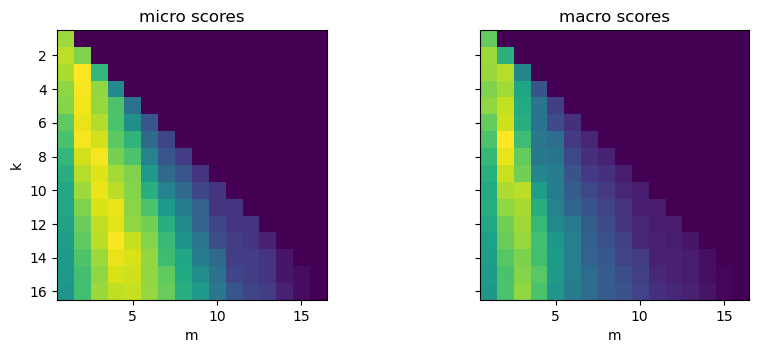

In [61]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")
plt.show()

m/k = 1/3의 비율로 선택할 때 성능이 가장 좋다.

In [62]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"최상의 k: {k}, 최상의 m: {m}")

최상의 k: 3, 최상의 m: 2


15개 최근접 이웃을 검색하고 최소한 5회 등장한 레이블을 할당할 때 최상의 성능 달성

In [63]:
# FAISS 인덱스는 데이터셋처럼 슬라이싱 하지 못하므로 인덱스 삭제
embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
    # 훈련 슬라이스로부터 FAISS 인덱스 생성
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index("embedding")
    # 검증 세트로 최상의 k, m 값 구함
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
    # 테스트 세트에서 예측 생성
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                           test_queries,
                                                           k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])

    clf_report = classification_report(test_labels, y_pred,
        target_names=mlb.classes_, zero_division=0, output_dict=True,)
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

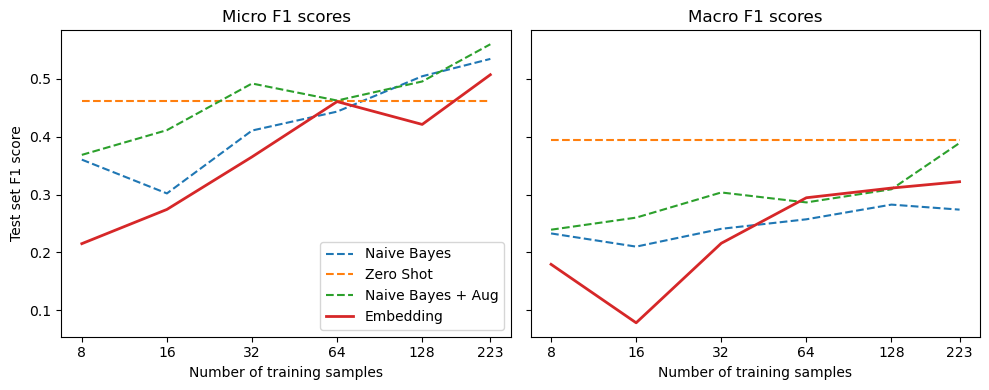

In [64]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")

임베딩 룩업은 학습 가능한 파라미터 k와 m을 가지며 마이크로 점수에서 이전 방법들에 비해 경쟁력이 있으나, 매크로 점수에서는 나쁜 성능 보임


* 기본 트랜스포머 미세 튜닝하기

In [29]:
import torch
from transformers import (AutoTokenizer, AutoConfig,
                          AutoModelForSequenceClassification)

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)
ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['labels', 'text'])

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [66]:
ds_enc.set_format("torch")
# 다중 레이블 손실 함수는 이산적인 레이블 대신 클래스 확률도 사용할 수 있기에 실수 타입의 레이블 기대
ds_enc = ds_enc.map(lambda x: {"label_ids_f": x["label_ids"].to(torch.float)},
                    remove_columns=["label_ids"])
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [34]:
from transformers import Trainer, TrainingArguments

training_args_fine_tune = TrainingArguments(
    output_dir="C:/Users/knuyh/Desktop", num_train_epochs=10, learning_rate=3e-5,
    lr_scheduler_type='constant', per_device_train_batch_size=4,
    per_device_eval_batch_size=32, weight_decay=0.0,
    evaluation_strategy="epoch", save_strategy="epoch",logging_strategy="epoch",
    load_best_model_at_end=True, metric_for_best_model='micro f1',
    # 크기가 작아 과대적합 가능성있기에 load_best_model_at_end=T 설정해 마이크로 F1점수 기반으로 최선의 모델 선택
    save_total_limit=1, log_level='error')

In [39]:
from scipy.special import expit as sigmoid

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)

    clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
                                     zero_division=0, output_dict=True)
    return {"micro f1": clf_dict["micro avg"]["f1-score"],
            "macro f1": clf_dict["macro avg"]["f1-score"]}

In [79]:
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

In [81]:
for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model, tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],)

    trainer.train()
    pred = trainer.predict(ds_enc["test"])
    metrics = compute_metrics(pred)
    macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"])
    micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\knuyh\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


{'loss': 0.6969, 'grad_norm': 2.955594778060913, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.6365318894386292, 'eval_micro f1': 0.09032258064516129, 'eval_macro f1': 0.04868032037843358, 'eval_runtime': 34.3965, 'eval_samples_per_second': 3.082, 'eval_steps_per_second': 0.116, 'epoch': 1.0}
{'loss': 0.6042, 'grad_norm': 2.7399063110351562, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.5899571180343628, 'eval_micro f1': 0.00980392156862745, 'eval_macro f1': 0.006006006006006006, 'eval_runtime': 36.4547, 'eval_samples_per_second': 2.908, 'eval_steps_per_second': 0.11, 'epoch': 2.0}
{'loss': 0.5342, 'grad_norm': 1.967198371887207, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.5278964638710022, 'eval_micro f1': 0.015037593984962405, 'eval_macro f1': 0.020202020202020204, 'eval_runtime': 35.1188, 'eval_samples_per_second': 3.018, 'eval_steps_per_second': 0.114, 'epoch': 3.0}
{'loss': 0.4916, 'grad_norm': 2.0630383491516113, 'learning_rate': 3e-05, 'epoch': 4.0}
{'e

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\knuyh\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


{'loss': 0.6068, 'grad_norm': 2.13637113571167, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.53438800573349, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 36.9253, 'eval_samples_per_second': 2.871, 'eval_steps_per_second': 0.108, 'epoch': 1.0}
{'loss': 0.5008, 'grad_norm': 2.1708035469055176, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.48149192333221436, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 28.3507, 'eval_samples_per_second': 3.739, 'eval_steps_per_second': 0.141, 'epoch': 2.0}
{'loss': 0.4479, 'grad_norm': 2.3027141094207764, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.4435657560825348, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 35.3469, 'eval_samples_per_second': 2.999, 'eval_steps_per_second': 0.113, 'epoch': 3.0}
{'loss': 0.4239, 'grad_norm': 1.9193183183670044, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.4211205840110779, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 29.5156,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\knuyh\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


{'loss': 0.6318, 'grad_norm': 3.0653915405273438, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5698016285896301, 'eval_micro f1': 0.08856088560885608, 'eval_macro f1': 0.030362177401865104, 'eval_runtime': 27.2407, 'eval_samples_per_second': 3.891, 'eval_steps_per_second': 0.147, 'epoch': 1.0}
{'loss': 0.5063, 'grad_norm': 2.0990960597991943, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.46627846360206604, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 36.0871, 'eval_samples_per_second': 2.937, 'eval_steps_per_second': 0.111, 'epoch': 2.0}
{'loss': 0.4284, 'grad_norm': 1.805504322052002, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.40700235962867737, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 29.4764, 'eval_samples_per_second': 3.596, 'eval_steps_per_second': 0.136, 'epoch': 3.0}
{'loss': 0.3738, 'grad_norm': 1.7160688638687134, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.3877612352371216, 'eval_micro f1': 0.0, 'eval_mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\knuyh\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


{'loss': 0.5655, 'grad_norm': 1.6792171001434326, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.4598151743412018, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 29.5764, 'eval_samples_per_second': 3.584, 'eval_steps_per_second': 0.135, 'epoch': 1.0}
{'loss': 0.4127, 'grad_norm': 1.0719095468521118, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.391986608505249, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 28.8875, 'eval_samples_per_second': 3.669, 'eval_steps_per_second': 0.138, 'epoch': 2.0}
{'loss': 0.3595, 'grad_norm': 1.2292033433914185, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3701026141643524, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 27.0054, 'eval_samples_per_second': 3.925, 'eval_steps_per_second': 0.148, 'epoch': 3.0}
{'loss': 0.3412, 'grad_norm': 1.4169788360595703, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.3585350215435028, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 27.181

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\knuyh\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


{'loss': 0.487, 'grad_norm': 1.6240442991256714, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.3882984220981598, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 32.0448, 'eval_samples_per_second': 3.308, 'eval_steps_per_second': 0.125, 'epoch': 1.0}
{'loss': 0.3538, 'grad_norm': 1.31842839717865, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.35235723853111267, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 27.9717, 'eval_samples_per_second': 3.79, 'eval_steps_per_second': 0.143, 'epoch': 2.0}
{'loss': 0.3404, 'grad_norm': 1.812044382095337, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3501034080982208, 'eval_micro f1': 0.125, 'eval_macro f1': 0.05555555555555555, 'eval_runtime': 36.4344, 'eval_samples_per_second': 2.909, 'eval_steps_per_second': 0.11, 'epoch': 3.0}
{'loss': 0.3254, 'grad_norm': 1.5201959609985352, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.3288854956626892, 'eval_micro f1': 0.03278688524590164, 'eval_macro f1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\knuyh\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


{'loss': 0.4477, 'grad_norm': 1.2185636758804321, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.36314353346824646, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 33.2076, 'eval_samples_per_second': 3.192, 'eval_steps_per_second': 0.12, 'epoch': 1.0}
{'loss': 0.3451, 'grad_norm': 1.2196104526519775, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.3358784317970276, 'eval_micro f1': 0.28169014084507044, 'eval_macro f1': 0.0966183574879227, 'eval_runtime': 29.4653, 'eval_samples_per_second': 3.597, 'eval_steps_per_second': 0.136, 'epoch': 2.0}
{'loss': 0.3039, 'grad_norm': 1.121067762374878, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.30534952878952026, 'eval_micro f1': 0.3246753246753247, 'eval_macro f1': 0.10659551176792556, 'eval_runtime': 36.2322, 'eval_samples_per_second': 2.926, 'eval_steps_per_second': 0.11, 'epoch': 3.0}
{'loss': 0.256, 'grad_norm': 1.7838715314865112, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.2562275528907776, 'eval

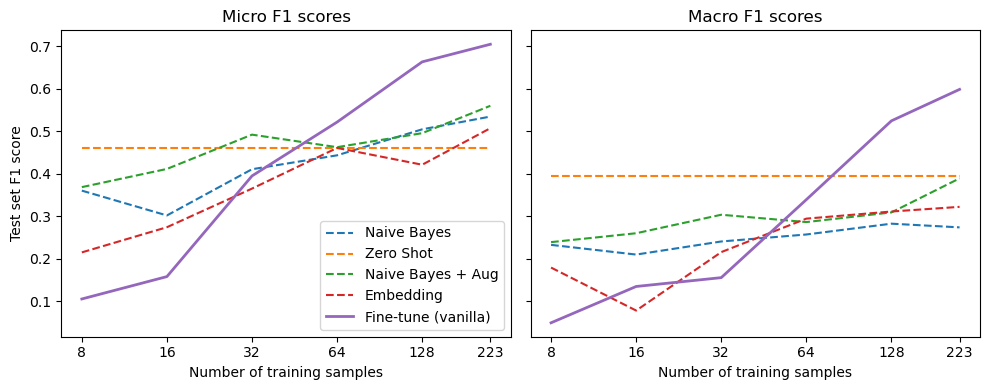

In [83]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")

BERT 모델 간단하게 미세 튜닝해 64개 샘플에서 경쟁력 있는 모델 얻음  
또 미세 튜닝 전에는 약간 불규칙한 행동 보이지만, 모델을 훈련한 작은 샘플의 레이블이 일부 불균형하기 때문

* 프롬프트를 사용한 인-컨텍스트 학습과 퓨-샷 학습  
   * 훈련데이터가 전혀 필요하지 않은 장점
   * 레이블링된 데이터를 활용할 수 없는 단점
   * 그 절충안으로 **인-컨텍스트 학습** 또는 **퓨샷 학습** 활용  
   
프롬프트 사용하고 모델의 토큰 예측을 파싱하여 작업에 특화된 헤드를 추가하고 모델 파라미터를 작업에 맞게 튜닝하는 전통적인 방식과 다름

In [5]:
# 모델이 단어 merci 예측하도록 유도 (영어 -> 프랑스어로 번역)
prompt = """\
Translate English to French:
thanks =>
"""

### 레이블링되지 않은 데이터 활용하기
* 도메인 적응(: 밑바닥부터 재훈련하는 대신 도메인의 데이터에서 계속 훈련)은 마스킹된 단어를 예측하는 고전적인 언어 모델의 목표를 사용하여 레이블링된 데이터가 필요하지 않다.
    * 그 후 적응된 모델을 분류기로 로드하고 미세 튜닝하여 레이블링되지 않은 데이터 활용
    * 레이블링된 데이터에 비해 레이블링되지 않은 데이터가 풍부한 경우가 많다.
    * 적응된 모델은 재사용된다.
    
<br>

* 언어 모델 미세 튜닝하기
    * 마스크드 언어 모델링으로 사전훈련된 BERT 모델을 레이블링이 없는 데이터셋에서 미세 튜닝
    * 데이터를 **토큰화**하는 추가 단계와 특별한 **데이터 콜레이터**
    
        * 토큰화 : 텍스트에 있는 일반적인 토큰 외에 분류와 다음 문장 예측에 사용할 [CLS]와 [SEP] 같은 특수 토큰도 시퀀스에 추가, 마스크드 언어 모델링에서는 이런 토큰도 예측하도록 모델을 훈련하지 않아 손실을 계산할 때 특수 토큰 마스킹함
        
        * 데이터 콜레이터 : 데이터셋과 모델 호출 사이를 연결하는 함수로, 배치는 데이터셋에서 샘플링되고 데이터 콜레이터는 배치에 있는 원소를 모델에 주입하기 위해 준비

In [30]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True,
                     max_length=128, return_special_tokens_mask=True) # 토큰화할 때 마스크 얻음

ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(["labels", "text", "label_ids"])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [31]:
from transformers import DataCollatorForLanguageModeling, set_seed

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                mlm_probability=0.15) # 모델의 토크나이저와 마스킹할 토큰 비율

In [32]:
set_seed(3)
data_collator.return_tensors = "np"
inputs = tokenizer("Transformers are awesome!", return_tensors="np")
original_input_ids = inputs["input_ids"][0]
outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])
masked_input_ids = outputs["input_ids"][0]

pd.DataFrame({
    "Original tokens": tokenizer.convert_ids_to_tokens(original_input_ids),
    "Masked tokens": tokenizer.convert_ids_to_tokens(masked_input_ids),
    "Original input_ids": original_input_ids,
    "Masked input_ids": masked_input_ids,
    "Labels": outputs["labels"][0]}).T

data_collator.return_tensors = "pt"

느낌표에 해당하는 토큰이 마스킹 토큰으로 변경  
데이터 콜레이터가 레이블 배열 반환 ;   
원본 토큰 = -100(손실 계산 시 무시됨), 마스킹된 토큰 = 토큰 ID

In [35]:
from transformers import AutoModelForMaskedLM

training_args = TrainingArguments(
    output_dir = f"{model_ckpt}-issues-128", per_device_train_batch_size=32,
    logging_strategy="epoch", evaluation_strategy="epoch", save_strategy="no",
    num_train_epochs=1, push_to_hub=True, log_level="error", report_to="none") # epoch=20


trainer = Trainer(
        model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"),
        tokenizer=tokenizer, args=training_args, data_collator=data_collator,
        train_dataset=ds_mlm["unsup"], eval_dataset=ds_mlm["train"])

trainer.train()

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\knuyh\anaconda3\L

Epoch,Training Loss,Validation Loss
1,2.160800,1.659455


TrainOutput(global_step=291, training_loss=2.160768489247745, metrics={'train_runtime': 66831.9916, 'train_samples_per_second': 0.139, 'train_steps_per_second': 0.004, 'total_flos': 612148593369600.0, 'train_loss': 2.160768489247745, 'epoch': 1.0})

In [ ]:
df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"] .plot(label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")
# 훈련과 검증 손실이 다른 간격으로 기록되기에 누락된 값 존재 -> 삭제

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

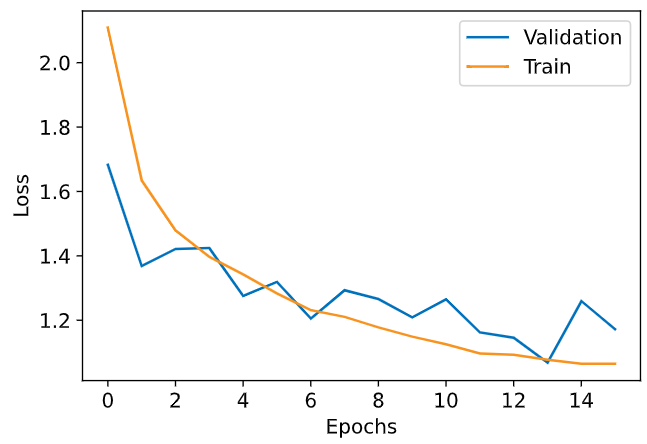

훈련, 검증 손실 모두 상당히 줄어들음

* 분류기 미세 튜닝하기

In [ ]:
model_ckpt = f'{model_ckpt}-issues-128' # bert-base-uncased

config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],
    )

    trainer.train()
    pred = trainer.predict(ds_enc['test'])
    metrics = compute_metrics(pred)
    # DA : 도메인 적응
    macro_scores['Fine-tune (DA)'].append(metrics['macro f1'])
    micro_scores['Fine-tune (DA)'].append(metrics['micro f1'])

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (DA)")

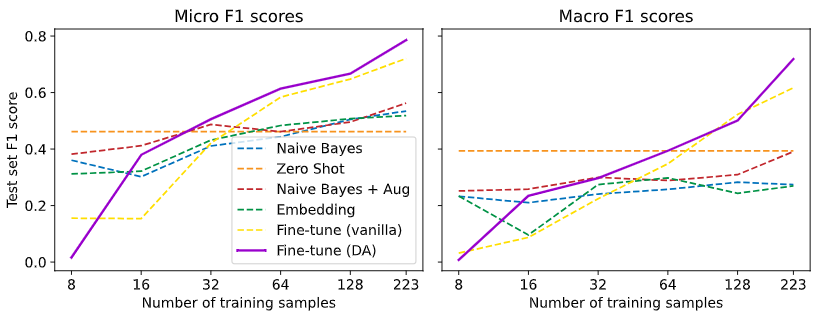

데이터가 부족한 도메인에서 유리하다. 레이블링된 데이터가 더 많은 상황에서는 향상되기도 한다.  

도메인 적응이 레이블링되지 않은 데이터와 약간의 노력을 통해 모델 성능을 조금 향상시킬 수 있다. 레이블링되지 않은 데이터가 많고, 레이블링된 데이터가 적을수록 이 방법이 미치는 영향은 더 커진다.

* 고급 방법
    * 비지도 데이터 증식(UDA)
        * 레이블링되지 않은 샘플과 살짝 왜곡된 샘플에 대해 모델의 예측이 일정해야 한다.
        * 왜곡은 토큰 교체나 역 번역 같은 표준적인 데이터 증식 전략으로 만든다.
        * 그 후 원본 예측과 왜곡된 샘플의 예측 사이에 KL 발산을 최소화하도록 일관성이 강제로 부여된다.
        * 레이블링되지 않은 샘플에 대한 항으로 크로스 엔트로피 손실을 보강해 일관성에 대한 요구사항 통합
        * 표준적인 지도 학습 방식으로 레이블링된 데이터에서 모델 훈련하지만, 레이블링되지 않은 데이터에서 일관된 예측을 만들도록 모델 제한
        * 데이터 증식 파이프라인이 필요하다는 단점
        * 레이블링되지 않은 샘플과 증식 샘플에 대해 예측을 만들기 위해 여러 번 정방향 패스를 실행해야 하므로 훈련 오래걸림
        
     * 불확실성 인지 자기 훈련(UST)
         * 레이블링되지 않은 데이터 활용
         * 레이블링된 데이터에서 티처 모델을 훈련하고 이 모델을 사용해 레이블링되지 않은 데이터에서 의사 레이블 만든다는 개념에 기초
         * 스튜던트 모델은 의사 레이블 데이터에서 훈련되고, 훈련 후 다음 반복에서 티처가 됨
         * 의사 레이블 생성 : 모델 예측의 불확실성 측정하기 위해 동일한 입력을 드롭아웃이 적용된 모델에 여러 번 주입

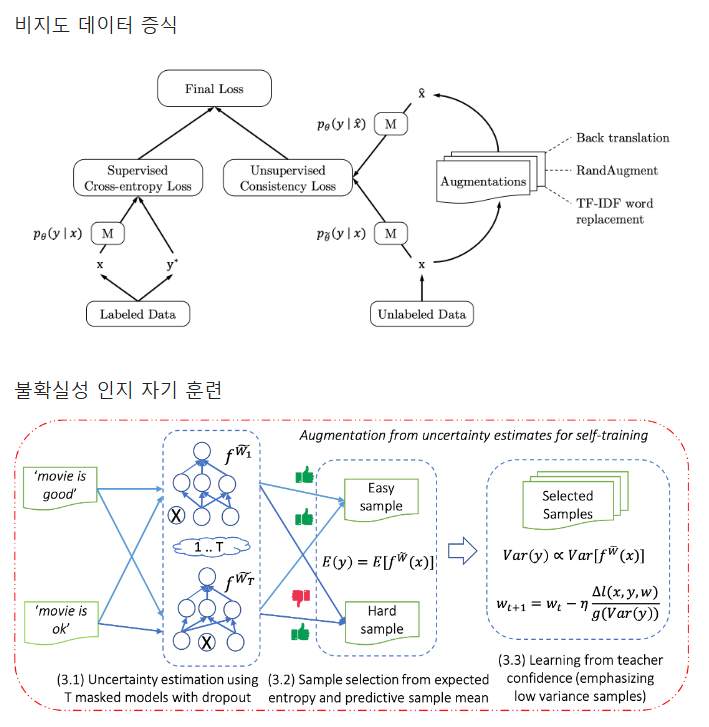